In [3]:
import time
import hydra
from hydra.utils import to_absolute_path
import torch
import sys
import os
import torch.nn as nn

import argparse

from dgl.dataloading import GraphDataLoader
import dgl
from omegaconf import DictConfig

from torch.cuda.amp import GradScaler, autocast
from torch.nn.parallel import DistributedDataParallel

#project_path = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', ''))
#sys.path.append(project_path)
project_path = os.path.abspath(os.path.join(os.getcwd(), '..', ''))
sys.path.append(project_path)

from python.create_dgl_dataset import TelemacDataset
from modulus.distributed.manager import DistributedManager
from modulus.launch.logging import (
    PythonLogger,
    RankZeroLoggingWrapper,
    initialize_wandb,
)
from modulus.launch.utils import load_checkpoint, save_checkpoint
from python.CustomMeshGraphNet import MeshGraphNet


In [17]:
from hydra.utils import to_absolute_path

In [18]:
import numpy as np

In [19]:
def collate_fn(batch):
    # batch is a list of sequences
    # Each sequence is a list of graphs (of length sequence_length)
    # We want to batch the graphs at each time step across sequences

    sequence_length = len(batch[0])  # Assuming all sequences have the same length

    batched_graphs = []
    for t in range(sequence_length):
        graphs_at_t = [sequence[t] for sequence in batch]
        batched_graph = dgl.batch(graphs_at_t)
        batched_graphs.append(batched_graph)

    return batched_graphs

class TestRollout:
    def __init__(self, cfg: DictConfig, logger: PythonLogger):
        self.sequence_length = cfg.sequence_length  # Use sequence_length from config
        self.overlap = cfg.overlap 
        # Set device
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        logger.info(f"Using {self.device} device")
        
        # Instantiate dataset
        self.dataset = TelemacDataset(
            name="telemac_test",
            data_dir=to_absolute_path(cfg.data_dir),
            dynamic_data_files=[to_absolute_path(path) for path in cfg.dynamic_dir],
            split="test",
            ckpt_path=cfg.ckpt_path,
            normalize=True,
            sequence_length=self.sequence_length,
            overlap=self.sequence_length
        )
        # Instantiate dataloader
        self.dataloader = GraphDataLoader(
            self.dataset,
            batch_size=1,  
            shuffle=False,
            drop_last=False,
            collate_fn=collate_fn,  # Use custom collate_fn if defined
        )
        print(f"DataLoader Length: {len(self.dataloader)}")

        # Instantiate the model
        self.model = MeshGraphNet(
            cfg.num_input_features,
            cfg.num_edge_features,
            cfg.num_output_features,
            processor_size=cfg.mp_layers,
            hidden_dim_processor=64,
            hidden_dim_node_encoder=64,
            hidden_dim_edge_encoder=64,
            hidden_dim_node_decoder=64,
            do_concat_trick=cfg.do_concat_trick,
            num_processor_checkpoint_segments=cfg.num_processor_checkpoint_segments,
        )
        if cfg.jit:
            self.model = torch.jit.script(self.model).to(self.device)
        else:
            self.model = self.model.to(self.device)

        # Set model to evaluation mode
        self.model.eval()

        # Load checkpoint
        load_checkpoint(
            to_absolute_path(cfg.ckpt_path),
            models=self.model,
            device=self.device,
            epoch=2000,
        )
        self.model = self.model.to(self.device)
        
        # Get the stats needed to denormalize and normalize
        node_stats = self.dataset.node_stats
        self.h_u_v_i_0_mean = np.array([
            node_stats['h'].item(),
            node_stats['u'].item(),
            node_stats['v'].item()
        ])
        self.h_u_v_i_0_std = np.array([
            node_stats['h_std'].item(),
            node_stats['u_std'].item(),
            node_stats['v_std'].item()
        ])

        self.delta_h_u_v_i_diff_mean = np.array([
            node_stats['delta_h'].item(),
            node_stats['delta_u'].item(),
            node_stats['delta_v'].item()
        ])
        self.delta_h_u_v_i_diff_std = np.array([
            node_stats['delta_h_std'].item(),
            node_stats['delta_u_std'].item(),
            node_stats['delta_v_std'].item()
        ])
        
        # Define feature indices
        self.dynamic_feature_start = 6  # Adjust based on your actual feature indices
        self.dynamic_feature_end = 9  # Adjust based on your actual feature indices
        
    def predict(self, graph):
        """
        Predicts the next time step given the input graph.
        Denormalizes input features and predictions.
        Returns the denormalized predicted values.
        """
        with torch.no_grad():
            pred = self.model(
                graph.ndata['x'].to(self.device),
                graph.edata['x'].to(self.device),
                graph.to(self.device)
            ).cpu().numpy()
        
        # Denormalize data
        h_u_v_i_0 = self._denormalize_data(
            graph.ndata['x'][:, self.dynamic_feature_start:self.dynamic_feature_end].numpy(),
            self.h_u_v_i_0_mean,
            self.h_u_v_i_0_std
        )

        # Compute predicted h, u, v at next time step
        h_u_v_i_1_pred = self._denormalize_data(
            pred,
            self.delta_h_u_v_i_diff_mean,
            self.delta_h_u_v_i_diff_std
        ) + h_u_v_i_0
                
        return h_u_v_i_1_pred, h_u_v_i_0
        
    def maj_mask(self, pred, next_step):
        """
        Updates predictions by applying boundary conditions from the next step.
        pred and next_step are normalized.
        """
        next_step_np = next_step.numpy()
        # Identify nodes with specific boundary conditions
        self.q_mask = (next_step_np[:, 0:4] == [0, 0, 1, 0]).all(axis=1)
        self.h_mask = (next_step_np[:, 0:4] == [0, 1, 0, 0]).all(axis=1)
        result = np.empty_like(next_step_np)
        
        # Copy static features from next_step
        result[:, 0:6] = next_step_np[:, 0:6]
        
        # Use predictions for dynamic features
        result[:, 6:9] = pred
        
        # Apply boundary conditions
        result[self.q_mask, 6:9] = next_step_np[self.q_mask, 6:9]
        result[self.h_mask, 6:7] = next_step_np[self.h_mask, 6:7]
        return result 
    
    def predict_unroll(self, unroll_steps=1):
        predict = []
        groundtruth = []
        origin = []
        for sequence in self.dataloader:
            # sequence is now a list of graphs
            sequence_length = len(sequence)
            if sequence_length < unroll_steps + 1:
                continue  # Skip sequences that are too short

            graph = sequence[0].clone()  # Start from the first graph in the sequence
            h_u_v_i_0 = None  # To store initial input at time t=0
            for i in range(unroll_steps):
                next_graph = sequence[i + 1]
                h_u_v_i_1_pred, h_u_v_i_0 = self.predict(graph)

                if i == 0:
                    origin.append(h_u_v_i_0)

                #noise_filter = h_u_v_i_1_pred[:, 0] < 5e-3
                #h_u_v_i_1_pred[noise_filter, :] = 0.0

                # Normalize the prediction to transfer to the next graph
                h_u_v_i_1_pred_norm = self._normalize_data(
                    h_u_v_i_1_pred,
                    self.h_u_v_i_0_mean,
                    self.h_u_v_i_0_std
                )

                # Apply boundary conditions
                next_step_result = self.maj_mask(
                    h_u_v_i_1_pred_norm,
                    next_graph.ndata['x']
                )

                # Update the graph's node features for the next prediction
                graph.ndata['x'] = torch.tensor(next_step_result, dtype=torch.float32)

            predict.append(h_u_v_i_1_pred)
            # Denormalize ground truth from next_graph
            groundtruth.append(self._denormalize_data(
                next_graph.ndata['x'][:, self.dynamic_feature_start:self.dynamic_feature_end].numpy(),
                self.h_u_v_i_0_mean,
                self.h_u_v_i_0_std
            ))

        return predict, groundtruth, origin

    def _denormalize_data(self, tensor, mean, std):
        assert tensor.shape[1] == mean.shape[0]
        return tensor * std + mean 
    
    def _normalize_data(self, tensor, mean, std):
        assert tensor.shape[1] == mean.shape[0]
        return (tensor - mean) / std
    
    def get_raw_data(self, idx):
        self.pred_i = [var[:, idx] for var in self.pred]
        self.exact_i = [var[:, idx] for var in self.exact]
        return self.graphs, self.faces, self.pred_i, self.exact_i



In [20]:
import hydra
from hydra import initialize, compose
from omegaconf import DictConfig, OmegaConf

import time 

# Initialize Hydra and set the configuration directory
with initialize(config_path="../bin/conf"):
    logger = PythonLogger("main")  # General python logger
    logger.file_logging()
    # Compose the configuration using the config name
    cfg = compose(config_name="Config1Group3Shortx8MultiTest")
    
    # Now call the training function with the composed config
    test = TestRollout(cfg,logger)
    
    predict,groundtruth,origin = test.predict_unroll(unroll_steps=12)
    

/tmp/ipykernel_380616/652760078.py:8: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../bin/conf"):
[17:33:52 - main - INFO] Using cuda device


Loading normalization statistics...


[17:33:52 - checkpoint - INFO] Loaded model state dictionary /work/m24046/m24046mrcr/new_tests_Group3/config1_short_x8_multimesh/MeshGraphNet.0.2000.mdlus to device cuda
[17:33:52 - checkpoint - INFO] Loaded checkpoint file /work/m24046/m24046mrcr/new_tests_Group3/config1_short_x8_multimesh/checkpoint.0.2000.pt to device cuda


DataLoader Length: 57


In [21]:
from python.python_code.data_manip.extraction.telemac_file import TelemacFile
from python.create_dgl_dataset import add_mesh_info

#mesh_list = ['/work/m24046/m24046mrcr/results_data_30min/maillage_3.slf']
mesh_list = ['/work/m24046/m24046mrcr/results_data_30min_35_70_maillagex8/Mesh8_corrige.slf']
res_mesh = TelemacFile(mesh_list[0])
X,triangles = add_mesh_info(res_mesh)

In [22]:
from python.python_code.data_manip.extraction.telemac_file import TelemacFile
from python.create_dgl_dataset import add_mesh_info

mesh_list = ['/work/m24046/m24046mrcr/results_data_30min/maillage_3.slf']
#mesh_list = ['/work/m24046/m24046mrcr/results_data_30min_35_70/maillage_3.slf']
res_mesh_fine = TelemacFile(mesh_list[0])
X_fine,triangles_fine = add_mesh_info(res_mesh_fine)

In [23]:
import pickle
from scipy.interpolate import griddata

fine_values = []
list_of_test_files = [
    '/work/m24046/m24046mrcr/results_data_30min_35_70/Group_3_peak_1600_Group_3_peak_1600_0_0-80.pkl',
    '/work/m24046/m24046mrcr/results_data_30min_35_70/Group_3_peak_2200_Group_3_peak_2200_0_0-80.pkl',
    '/work/m24046/m24046mrcr/results_data_30min_35_70/Group_3_peak_3200_Group_3_peak_3200_0_0-80.pkl'
]
#list_of_test_files = ['/work/m24046/m24046mrcr/results_data_30min_35_70/Group_3_peak_2200_Group_3_peak_2200_0_0-80.pkl']

#list_of_test_files = ['/work/m24046/m24046mrcr/results_data_30min/Group_3_peak_1600_Group_3_peak_1600_0_0-80.pkl',
#                '/work/m24046/m24046mrcr/results_data_30min/Group_3_peak_2200_Group_3_peak_2200_0_0-80.pkl',
#                '/work/m24046/m24046mrcr/results_data_30min/Group_3_peak_3200_Group_3_peak_3200_0_0-80.pkl']


In [24]:
sequence_length = 13
overlap = 13
sequences = []
for file_path in list_of_test_files:
    with open(file_path, 'rb') as f:
        dynamic_data = pickle.load(f)
        step = max(1, sequence_length - overlap)
        for i in range(0, len(dynamic_data) - sequence_length + 1, step):
            sequence = dynamic_data[i:i + sequence_length]
            sequences.append(sequence)

In [25]:
fine_gd = []
fine_ori = []
for seq in sequences : 
    a,b = seq[-1]
    correct = a+b
    fine_gd.append(correct)
    fine_ori.append(seq[0][0])

### Projection

In [26]:
from matplotlib.tri import Triangulation
from scipy.spatial import Delaunay

fine_data = fine_gd

# Prepare grid points
# Define your domain bounds and grid resolution
xmin = min(X[:, 0].min(), X_fine[:, 0].min())
xmax = max(X[:, 0].max(), X_fine[:, 0].max())
ymin = min(X[:, 1].min(), X_fine[:, 1].min())
ymax = max(X[:, 1].max(), X_fine[:, 1].max())
Nx, Ny = 700, 700  # Adjust as needed

grid_x, grid_y = np.mgrid[xmin:xmax:Nx*1j, ymin:ymax:Ny*1j]
grid_points = np.vstack((grid_x.ravel(), grid_y.ravel())).T  # Shape: (n_grid_points, 2)

# Create a mask for the domain using the fine mesh triangulation
triangulation_mask = Triangulation(X_fine[:, 0], X_fine[:, 1], triangles=triangles_fine)
mask = triangulation_mask.get_trifinder()(grid_x, grid_y) != -1  # True inside the domain
mask_flat = mask.ravel()

# Precompute triangulations
tri_fine = Delaunay(X_fine)
tri_coarse = Delaunay(X)

# Compute simplex indices for fine and coarse meshes
simplex_indices_fine = tri_fine.find_simplex(grid_points)
simplex_indices_coarse = tri_coarse.find_simplex(grid_points)

# Apply the mask to simplex indices
simplex_indices_fine_masked = np.where(mask_flat, simplex_indices_fine, -1)
simplex_indices_coarse_masked = np.where(mask_flat, simplex_indices_coarse, -1)

# Identify valid points inside the domain and within a simplex
valid_fine = simplex_indices_fine_masked >= 0
valid_coarse = simplex_indices_coarse_masked >= 0

# Compute barycentric coordinates for valid points on fine mesh
transform_fine = tri_fine.transform[simplex_indices_fine_masked[valid_fine], :2]
offset_fine = tri_fine.transform[simplex_indices_fine_masked[valid_fine], 2]
delta_fine = grid_points[valid_fine] - offset_fine
bary_coords_fine = np.einsum('ijk,ik->ij', transform_fine, delta_fine)
bary_coords_fine = np.hstack((bary_coords_fine, 1 - bary_coords_fine.sum(axis=1, keepdims=True)))

# Compute barycentric coordinates for valid points on coarse mesh
transform_coarse = tri_coarse.transform[simplex_indices_coarse_masked[valid_coarse], :2]
offset_coarse = tri_coarse.transform[simplex_indices_coarse_masked[valid_coarse], 2]
delta_coarse = grid_points[valid_coarse] - offset_coarse
bary_coords_coarse = np.einsum('ijk,ik->ij', transform_coarse, delta_coarse)
bary_coords_coarse = np.hstack((bary_coords_coarse, 1 - bary_coords_coarse.sum(axis=1, keepdims=True)))

# Interpolation function without numba
def interpolate_values(tri_simplices, simplex_indices, bary_coords, values, valid_indices, n_grid_points):
    n_variables = values.shape[1]
    result = np.full((n_grid_points, n_variables), 0.0)
    for idx, i in enumerate(valid_indices):
        simplex_index = simplex_indices[idx]
        indices = tri_simplices[simplex_index]
        bc = bary_coords[idx]
        v = values[indices]
        interpolated_value = np.dot(bc, v)
        result[i] = interpolated_value
    return result

# Number of grid points
n_grid_points = grid_points.shape[0]

# Interpolate fine data
fine_gd_grid = []
for fine_data in fine_gd:
    interpolated_values = interpolate_values(
        tri_fine.simplices,
        simplex_indices_fine_masked[valid_fine],
        bary_coords_fine,
        fine_data,
        np.where(valid_fine)[0],
        n_grid_points
    )
    # Reshape to grid shape and number of variables
    interpolated_values = interpolated_values.reshape((grid_x.shape[0], grid_x.shape[1], -1))
    fine_gd_grid.append(interpolated_values)

# Interpolate coarse predictions
projected_predi = []
for pred in predict:
    interpolated_values = interpolate_values(
        tri_coarse.simplices,
        simplex_indices_coarse_masked[valid_coarse],
        bary_coords_coarse,
        pred,
        np.where(valid_coarse)[0],
        n_grid_points
    )
    # Reshape to grid shape and number of variables
    interpolated_values = interpolated_values.reshape((grid_x.shape[0], grid_x.shape[1], -1))
    projected_predi.append(interpolated_values)

In [27]:
import numpy as np

# Dimensions de la grille
N_x, N_y = 700, 700

# Création d'une fenêtre de Hann en 2D
w_x = np.hanning(N_x)
w_y = np.hanning(N_y)
window_2d = np.outer(w_x, w_y)  # fenêtre 2D, shape (700,700)

# Analyse spectrale pour fine_gd_grid
fine_spectra = []
for data in fine_gd_grid:
    # data est de taille (700,700,3)
    # On applique la fenêtre à toutes les variables (3) simultanément
    data_windowed = data * window_2d[:, :, None]  # broadcasting sur la dernière dimension

    # FFT 2D sur les deux premières dimensions (x,y) pour chaque variable
    data_fft = np.fft.fft2(data_windowed, axes=(0, 1))
    
    # Optionnel : décaler le spectre pour placer la composante basse fréquence au centre
    data_fft_shifted = np.fft.fftshift(data_fft, axes=(0, 1))
    
    fine_spectra.append(data_fft_shifted)

# Analyse spectrale pour projected_predi
projected_spectra = []
for data in projected_predi:
    # data est de taille (700,700,3)
    data_windowed = data * window_2d[:, :, None]
    data_fft = np.fft.fft2(data_windowed, axes=(0, 1))
    data_fft_shifted = np.fft.fftshift(data_fft, axes=(0, 1))
    projected_spectra.append(data_fft_shifted)

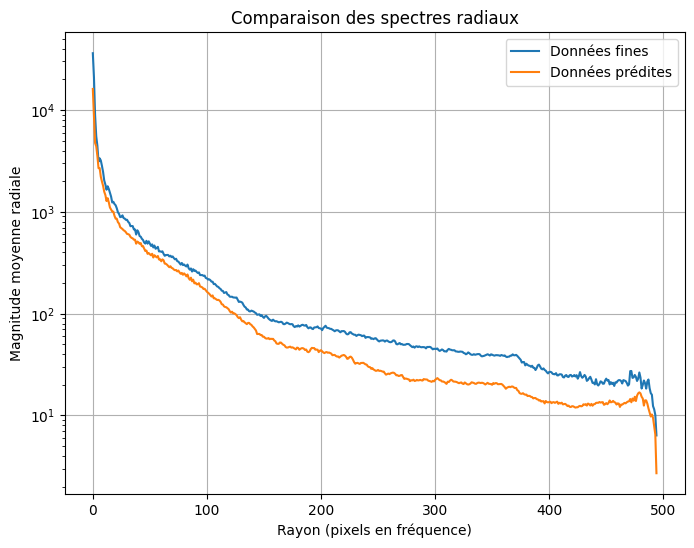

In [28]:
import matplotlib.pyplot as plt

def radial_average_spectrum(spectrum, center=None):
    """
    Calcule la moyenne radiale du spectre.
    spectrum : tableau 2D avec la magnitude du spectre (par ex. abs(fft))
    center : (x0, y0) centre du spectre. Si None, on prend le centre de l'image.
    Retourne r, rad_ave
    où r est le rayon (en nombre de pixels) et rad_ave est la valeur moyenne pour ce rayon.
    """
    ny, nx = spectrum.shape
    if center is None:
        center = (nx//2, ny//2)
    x0, y0 = center

    # Création des coordonnées
    y, x = np.indices((ny, nx))
    r = np.sqrt((x - x0)**2 + (y - y0)**2)

    # Rayons arrondis pour regrouper les pixels par distance du centre
    r_int = r.astype(int)
    r_max = r_int.max()

    rad_ave = np.zeros(r_max+1, dtype=np.float64)
    counts = np.zeros(r_max+1, dtype=np.float64)

    # Accumule les valeurs par rayon
    for i in range(ny):
        for j in range(nx):
            ri = r_int[i, j]
            rad_ave[ri] += spectrum[i, j]
            counts[ri] += 1

    # Moyenne radiale
    rad_ave = np.divide(rad_ave, counts, out=np.zeros_like(rad_ave), where=counts>0)

    # Tableau des rayons (en pixels)
    r_vals = np.arange(r_max+1)
    return r_vals, rad_ave


# Choix du pas de temps (par exemple le premier)
t_index = 40

# Choix de la variable (0, 1 ou 2)
var_index = 0

# Récupération des spectres pour ce pas de temps et cette variable
fine_fft = fine_spectra[t_index][:, :, var_index]       # FFT données fines
projected_fft = projected_spectra[t_index][:, :, var_index]  # FFT prédictions

# Calcul de la magnitude des spectres
fine_mag = np.abs(fine_fft)
projected_mag = np.abs(projected_fft)

# Moyenne radiale
nx, ny = fine_mag.shape
center = (nx//2, ny//2)
r_fine, rad_fine = radial_average_spectrum(fine_mag, center=center)
r_proj, rad_proj = radial_average_spectrum(projected_mag, center=center)

# Visualisation
plt.figure(figsize=(8,6))
plt.plot(r_fine, rad_fine, label='Données fines')
plt.plot(r_proj, rad_proj, label='Données prédites')
plt.xlabel('Rayon (pixels en fréquence)')
plt.ylabel('Magnitude moyenne radiale')
plt.title('Comparaison des spectres radiaux')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

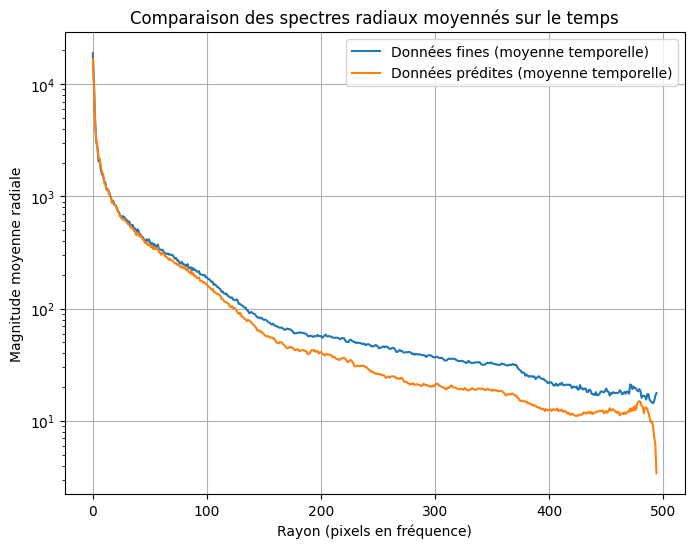

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def radial_average_spectrum(spectrum, center=None):
    """
    Calcule la moyenne radiale du spectre.
    spectrum : tableau 2D avec la magnitude du spectre (par ex. abs(fft))
    center : (x0, y0) centre du spectre. Si None, on prend le centre.
    Retourne: r_vals, rad_ave
    """
    ny, nx = spectrum.shape
    if center is None:
        center = (nx//2, ny//2)
    x0, y0 = center

    # Création des coordonnées
    y, x = np.indices((ny, nx))
    r = np.sqrt((x - x0)**2 + (y - y0)**2)

    # Rayons arrondis
    r_int = r.astype(int)
    r_max = r_int.max()

    rad_ave = np.zeros(r_max+1, dtype=np.float64)
    counts = np.zeros(r_max+1, dtype=np.float64)

    # Accumulation par rayon
    for i in range(ny):
        for j in range(nx):
            ri = r_int[i, j]
            rad_ave[ri] += spectrum[i, j]
            counts[ri] += 1

    # Moyenne
    rad_ave = np.divide(rad_ave, counts, out=np.zeros_like(rad_ave), where=counts>0)
    r_vals = np.arange(r_max+1)
    return r_vals, rad_ave

# Supposons que fine_spectra et projected_spectra sont déjà définies
# fine_spectra et projected_spectra sont des listes de taille (N_t) 
# où N_t est le nombre de pas de temps, 
# chaque élément est un tableau (700, 700, 3).

N_t = len(fine_spectra)
var_index = 0  # Choix de la variable

rad_fine_all = []
rad_proj_all = []

for t in range(N_t):
    fine_fft = fine_spectra[t][:, :, var_index]
    proj_fft = projected_spectra[t][:, :, var_index]

    fine_mag = np.abs(fine_fft)
    proj_mag = np.abs(proj_fft)

    nx, ny = fine_mag.shape
    center = (nx//2, ny//2)

    r_fine, rad_fine = radial_average_spectrum(fine_mag, center=center)
    r_proj, rad_proj = radial_average_spectrum(proj_mag, center=center)

    rad_fine_all.append(rad_fine)
    rad_proj_all.append(rad_proj)

# Conversion en tableau pour un traitement facile
rad_fine_all = np.array(rad_fine_all)  # shape (N_t, r_max+1)
rad_proj_all = np.array(rad_proj_all)  # shape (N_t, r_max+1)

# Moyenne sur le temps
rad_fine_mean = rad_fine_all.mean(axis=0)
rad_proj_mean = rad_proj_all.mean(axis=0)

# Visualisation de la moyenne temporelle du spectre radial
plt.figure(figsize=(8,6))
plt.plot(r_fine, rad_fine_mean, label='Données fines (moyenne temporelle)')
plt.plot(r_proj, rad_proj_mean, label='Données prédites (moyenne temporelle)')
plt.xlabel('Rayon (pixels en fréquence)')
plt.ylabel('Magnitude moyenne radiale')
plt.title('Comparaison des spectres radiaux moyennés sur le temps')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()


In [30]:
np.save("./datas/rad_proj_mean_x8.npy", np.array(rad_proj_mean))
np.save("./datas/r_proj_x8.npy", np.array(r_proj))

In [35]:
np.save("./datas/rad_proj_mean_fine.npy", np.array(rad_fine_mean))
np.save("./datas/r_fine.npy", np.array(r_fine))

In [4]:
import numpy as np
import matplotlib.pyplot as plt


rad_proj_mean_x1 = np.load("./datas/rad_proj_mean_x1.npy")
r_proj_x1 = np.load("./datas/r_proj_x1.npy")

rad_proj_mean_x8 = np.load("./datas/rad_proj_mean_x8.npy")
r_proj_x8 = np.load("./datas/r_proj_x8.npy")

rad_proj_mean_gd = np.load("./datas/rad_proj_mean_fine.npy")
r_proj_gd = np.load("./datas/r_fine.npy")

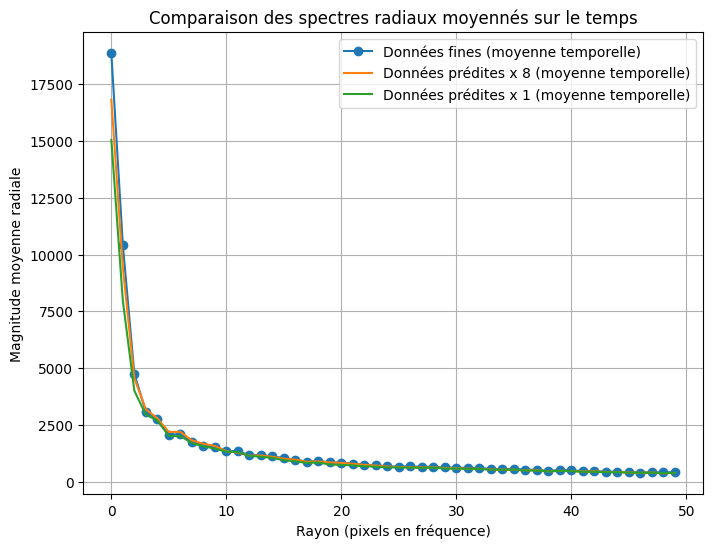

In [7]:
# Visualisation de la moyenne temporelle du spectre radial
plt.figure(figsize=(8,6))
plt.plot(r_proj_gd[:50], rad_proj_mean_gd[:50],marker='o', label='Données fines (moyenne temporelle)')
plt.plot(r_proj_x8[:50], rad_proj_mean_x8[:50], label='Données prédites x 8 (moyenne temporelle)')
plt.plot(r_proj_x1[:50], rad_proj_mean_x1[:50], label='Données prédites x 1 (moyenne temporelle)')

plt.xlabel('Rayon (pixels en fréquence)')
plt.ylabel('Magnitude moyenne radiale')
plt.title('Comparaison des spectres radiaux moyennés sur le temps')
plt.legend()
#plt.yscale('log')
plt.grid(True)
plt.show()

In [13]:
print(rad_proj_mean_x8[:100])

[16828.45011899  9433.55826601  4549.34497637  3183.83586477
  2785.2924659   2182.74311184  2189.05755171  1816.51220265
  1664.02491741  1569.27876124  1333.04563316  1274.42193285
  1136.51324879  1146.76495503  1088.72611089  1004.6607738
   963.91820176   868.84564957   885.3247067    840.85646817
   823.9197653    780.58867924   734.4938359    703.48831659
   660.56900647   641.14268364   626.83572387   622.27542012
   621.32585553   597.32593378   578.41589995   564.65976179
   559.66517127   529.78500856   523.23218943   520.64237043
   493.73186454   494.01052728   451.2781874    472.11983128
   465.52591587   439.046965     448.31247941   423.62489062
   418.88859714   397.73452267   384.43938002   393.15999575
   366.14350861   376.96050045   367.65902837   352.5894243
   362.41018092   338.02345072   354.79387956   338.95430501
   338.7426459    344.99615341   316.83193323   315.93920105
   301.59574228   313.91731257   310.80849382   295.45919411
   293.67667661   284.5874